Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [3]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
print(train.shape)
train.head()

(59400, 41)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [5]:
# spiltting the dataset into train, and val
train, val = train_test_split(train, train_size=.80, test_size=.20, stratify=train['status_group'], random_state=10)
train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [6]:
# frequency of the class
train['status_group'].value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [7]:
train.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    2895
gps_height                   0
installer                 2914
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 305
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            2654
recorded_by                  0
scheme_management         3072
scheme_name              22554
permit                    2432
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [8]:
train[['latitude', 'longitude']].describe()

,latitude,longitude
count,4.752000e+04,47520.000000
mean,-5.697647e+00,34.045131
std,2.948272e+00,6.627727
min,-1.164944e+01,0.000000
25%,-8.539884e+00,33.080718
50%,-5.013754e+00,34.890534
75%,-3.323718e+00,37.169591
max,-2.000000e-08,40.345193


In [0]:
import numpy as np

def wrangle(data):
  '''wrangle data in train, val, test sets in the same way'''
  data = data.copy()
  data['latitude'] = data['latitude'].replace(-2e-08, 0)

  columns = ['longitude', 'latitude', 'population']
  for col in columns:
    data[col] = data[col].replace(0, np.NaN)
  return data

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [10]:
train['latitude'].isnull().sum()

1483

In [11]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
35987,61749,0.0,2013-03-21,Wcst,695,Engarasero villagers,35.885542,-2.631638,Cultural Boma,0,Internal,Engaresero,Arusha,2,5,Ngorongoro,Pinyinyi,150.0,True,GeoData Consultants Ltd,VWC,NaN,NaN,2012,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe multiple,communal standpipe,functional
51881,48384,0.0,2011-03-09,Government Of Tanzania,0,Gove,35.661258,-6.368428,Kwa Sc,0,Internal,Jamuhu,Dodoma,1,6,Bahi,Chibelela,NaN,True,GeoData Consultants Ltd,VWC,Chib,True,0,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
32041,34195,0.0,2013-03-26,Government Of Tanzania,1405,DWE,37.514717,-3.284003,Kwa Joseph Mali,0,Pangani,Moori,Kilimanjaro,3,4,Moshi Rural,Marangu Mashariki,1.0,False,GeoData Consultants Ltd,VWC,Marangu baraza,True,1972,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,other,other,non functional
48947,28136,0.0,2011-02-27,Government Of Tanzania,11,Centr,38.636150,-7.862210,Kidiamiangi,0,Rufiji,Nyasungwi,Pwani,60,53,Rufiji,Ngorongo,1625.0,True,GeoData Consultants Ltd,VWC,NaN,True,1974,mono,mono,motorpump,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,non functional
57659,2716,0.0,2011-07-29,NaN,0,NaN,33.689777,-9.454573,Kwa Mina,0,Lake Nyasa,Ilima,Mbeya,12,4,Rungwe,Ilima,NaN,True,GeoData Consultants Ltd,VWC,M,NaN,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,non functional


In [12]:
train['construction_year'].dtypes

dtype('int64')

In [13]:
train.select_dtypes(include='number').describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,47520.000000,47520.000000,47520.000000,46037.000000,46037.000000,47520.000000,47520.000000,47520.000000,30337.000000,47520.000000
mean,37140.295854,312.601359,668.290173,35.141835,-5.881186,0.481481,15.303178,5.619697,282.901836,1298.104209
std,21446.914534,2945.876135,694.285159,2.607838,2.809425,13.092398,17.548231,9.616672,574.052745,952.435038
min,0.000000,0.000000,-90.000000,29.607122,-11.649440,0.000000,1.000000,0.000000,1.000000,0.000000
25%,18585.500000,0.000000,0.000000,33.279353,-8.644724,0.000000,5.000000,2.000000,40.000000,0.000000
50%,37096.500000,0.000000,366.000000,34.993079,-5.171917,0.000000,12.000000,3.000000,150.000000,1985.000000
75%,55733.250000,20.000000,1321.000000,37.223607,-3.371355,0.000000,17.000000,5.000000,326.000000,2004.000000
max,74246.000000,350000.000000,2628.000000,40.345193,-0.998464,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [14]:
train['population'].isnull().sum()

17183

In [15]:
train.select_dtypes(exclude='number').describe().T.sort_values(by='unique')

,count,unique,top,freq
recorded_by,47520,1,GeoData Consultants Ltd,47520
public_meeting,44866,2,True,40802
permit,45088,2,True,31020
status_group,47520,3,functional,25807
source_class,47520,3,groundwater,36656
quantity_group,47520,5,enough,26613
quantity,47520,5,enough,26613
management_group,47520,5,user-group,41983
quality_group,47520,6,good,40666
waterpoint_type_group,47520,6,communal standpipe,27701


In [16]:
import plotly.express as px
px.scatter(train, x='longitude', y='latitude', color='status_group', opacity=0.1)

In [17]:
train.select_dtypes(exclude='number').nunique()

date_recorded              347
funder                    1691
installer                 1902
wpt_name                 30739
basin                        9
subvillage               17188
region                      21
lga                        125
ward                      2085
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2537
permit                       2
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
status_group                 3
dtype: int64

In [18]:
# the target for the data
target = 'status_group'

# columns dropped as some are repeated and some have no influence towards the response y
to_drop = ['recorded_by', 'id', 'quantity_group']
train_features = train.drop([target] + to_drop, axis=1)

# list of numeric features
numeric_features = train_features.select_dtypes(include='number').columns.to_list()

# series of nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# list of categorical features with cardinality <=25
categorical_features = cardinality[cardinality <= 25].index.to_list()

# combined list to make a new list
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [0]:
# arrange data into X features matrix and y target vector

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [20]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(min_samples_leaf=20, random_state=10)
)

pipeline.fit(X_train, y_train)


# Score on train, val
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

# Predict on test
y_pred = pipeline.predict(X_test)

Train Accuracy 0.8098905723905724
Validation Accuracy 0.7645622895622896


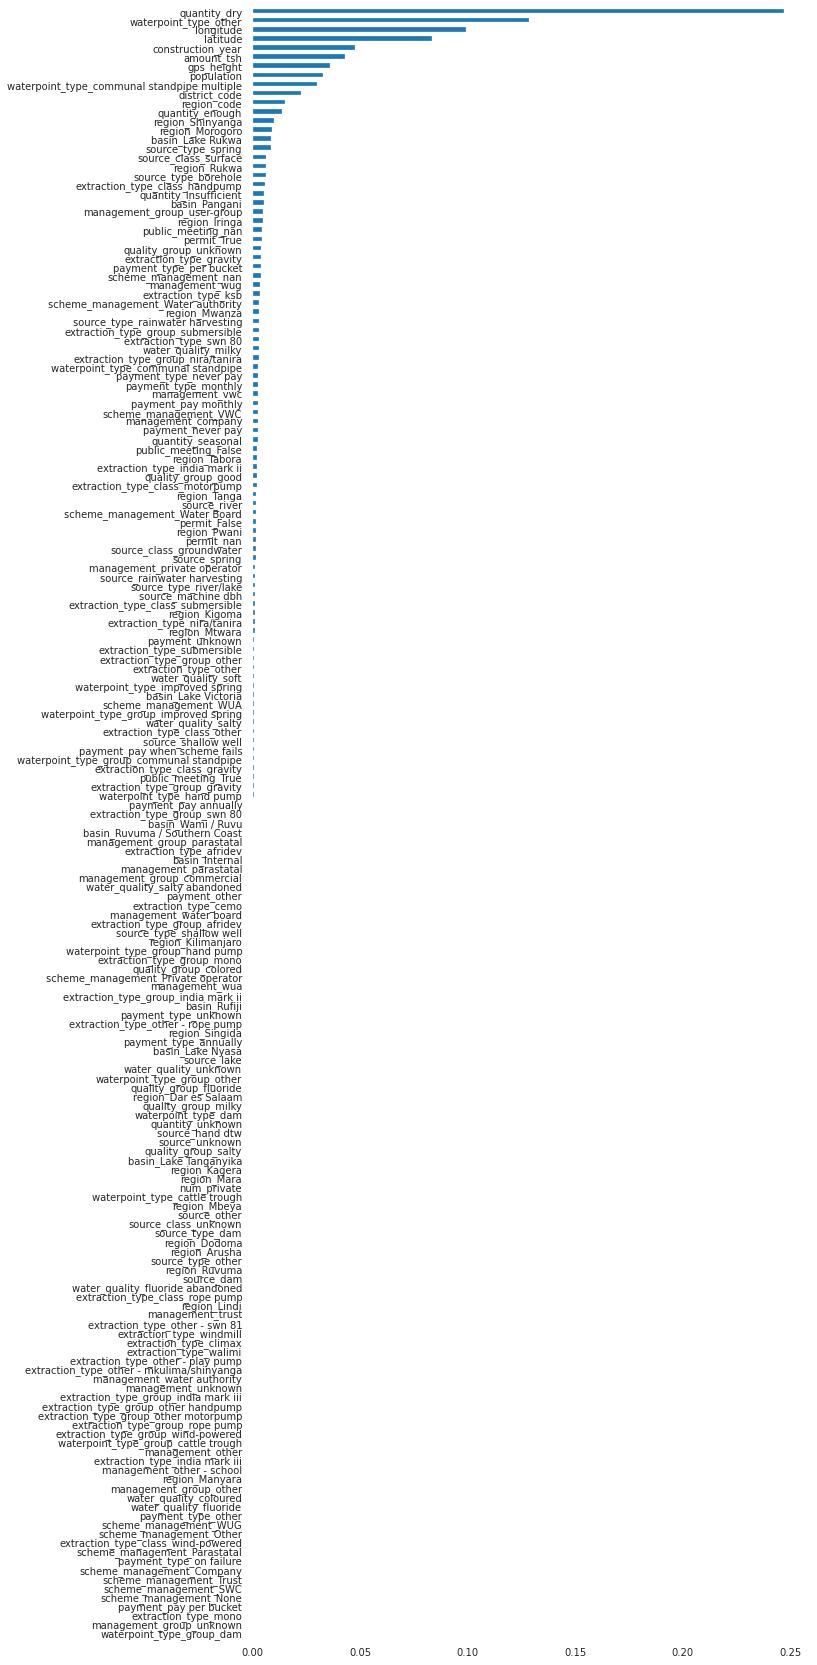

In [21]:
import matplotlib.pyplot as plt


model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh();

In [0]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('nirmal_kaggle_comp.csv', index=False)

In [25]:
sample_submission

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,functional
4,49871,functional
...,...,...
14353,39307,functional
14354,18990,functional
14355,28749,functional
14356,33492,functional


In [28]:
submission

,id,status_group
0,50785,non functional
1,51630,non functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14353,39307,non functional
14354,18990,functional
14355,28749,functional
14356,33492,functional
